In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.642486  0.944797  0.416451  0.800687  0.556052 -0.419304 -0.024410   
  1  -0.062111  0.126978  0.003995  0.148548  1.182845  0.864303  0.564745   
  2  -0.196094  0.532482  0.705052 -0.332047  0.171626  0.599659  0.226598   
  3  -0.241355  0.351155  0.996687  0.887602  0.583638  0.967623  0.052720   
  4   0.362958  0.153126  0.680998  0.334802  0.467542 -0.404068  0.248783   
  5   0.206257 -0.286748  0.609371  0.780696  0.522080  0.490728 -0.167180   
  6   0.834595  0.199019  0.940764  0.611483  1.568640  1.279507  0.538869   
  7   1.369218  1.272808  0.407938 -0.449965 -0.511931 -0.709532 -0.122084   
  8   0.721577  0.949578 -0.947209 -0.750951  0.044718 -0.651352  0.094978   
  9  -0.905352  0.312105  0.382558  1.112849 -0.045463 -1.267247  0.227155   
  10 -0.227433  0.306598  0.503204  0.857459  0.475554  0.596403  0.041493   
  11  1.051095  0.105694  0.566678  1.127224  0.157645 -0.377588  0.448565   
  12 -0.102045 -0.517626  0.076245  0.082343  0.027421  0.637492  1.244284   
  13 -0.427525 -0.412960 -0.037897  0.142060  0.761096  0.998298 -0.152411   
  14 -0.015763 -0.686966 -0.589742  0.073728 -0.353594  1.434193  0.840862   
  15  0.360236 -0.327503 -0.664473 -0.215429 -0.106112 -0.045088  0.035346   
  16 -0.539672 -0.003325 -0.126542 -0.272354  0.593391  0.884960 -0.421879   
  17 -0.436886 -0.199632 -0.106329 -0.297354  1.067149  0.115878  0.171578   
  18 -0.411254  0.095255  0.686180  0.209621  0.042154  1.124316 -0.193244   
  19 -0.052239  0.457540 -0.314914  0.811554  1.093174  0.251732 -0.290355   
  20  0.031715  0.374981  0.694655 -0.434898  0.150841 -0.496457  0.627505   
  21 -0.249488  0.980441  0.625450  0.050231  0.998538 -0.118002  0.312800   
  22  1.209437  0.285628 -0.134869  0.976272 -0.176531 -0.610720 -0.743938   
  23 -0.395823  0.194887  0.322932  0.480625  0.769332  0.133029 -0.443154   
  24 -0.471173 -0.429328  0.334820  0.031782  0.055171  0.192505  0.130181   
1 0   0.209452 -0.096098 -0.328949  0.145107 -0.213119 -0.456219  0.420609   
  1   0.399913  0.101562 -0.061908 -0.458496  0.444423  0.451617  0.704770   
  2   0.195980  0.027591 -0.431464 -0.030568  1.754680 -0.370472 -0.029903   
  3  -0.579001 -0.446748  0.276975  0.735075 -0.513858 -0.265129  0.481802   
  4   0.280318 -0.860588  0.329918  0.017893  0.515920 -0.182959  0.277523   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.804263 -0.996101 -0.577971  ... -0.148547  0.835454  0.368265   
  1   0.275110  0.086208  0.429305  ... -0.371551  0.568199 -1.195608   
  2  -0.246668  0.564015 -0.289388  ...  0.411823  0.295528  0.006084   
  3   0.829442  0.044841 -0.148085  ... -0.312318  0.801070  0.198961   
  4  -0.449564 -0.680665  0.422379  ...  0.041997 -0.516563  0.375817   
  5   0.329343 -0.318823  0.715950  ... -0.658753  1.041393  0.872031   
  6  -0.242708 -0.753314 -0.246520  ...  0.290137  0.277084  0.057088   
  7   0.507495  1.709106 -0.769061  ...  0.470096 -0.375432 -0.253330   
  8  -0.251314 -0.129308  0.855196  ... -0.354176 -0.805849 -0.665666   
  9  -0.012962  0.554220 -0.111363  ...  0.165907  0.405759  0.355006   
  10  1.049752 -0.557066 -0.275606  ...  0.417298 -0.098654  0.417080   
  11 -0.067887  0.086569 -0.501582  ... -0.263857  0.166295 -0.132278   
  12 -0.966356 -0.185380 -0.348900  ... -0.480921  1.149339  0.536887   
  13 -0.270022 -0.953557 -0.989440  ...  1.213759  0.812496 -0.545423   
  14  0.794478 -0.592409 -0.177213  ...  0.441339  0.089935 -0.471778   
  15  0.245402 -0.301457 -0.971797  ...  1.293287  0.557329  0.382798   
  16 -0.399404 -0.899536  0.230148  ... -0.340153 -0.244618 -0.212585   
  17  0.428114 -0.370533 -0.089519  ... -0.282069  0.015696 -0.324011   
  18 -1.688208 -0.951880  0.963024  ... -0.706215  0.607183  0.445279   
  19 -0.804436 -0.781775 -0.445897  ...  0.947214  0.996016  0.556517   
  20  1.222441  0.597190 -0.331039  ...  0.754456 -0.569355 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  0.948578  0.041967  22.602847  4.063172e-113  0.866324  1.030832


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



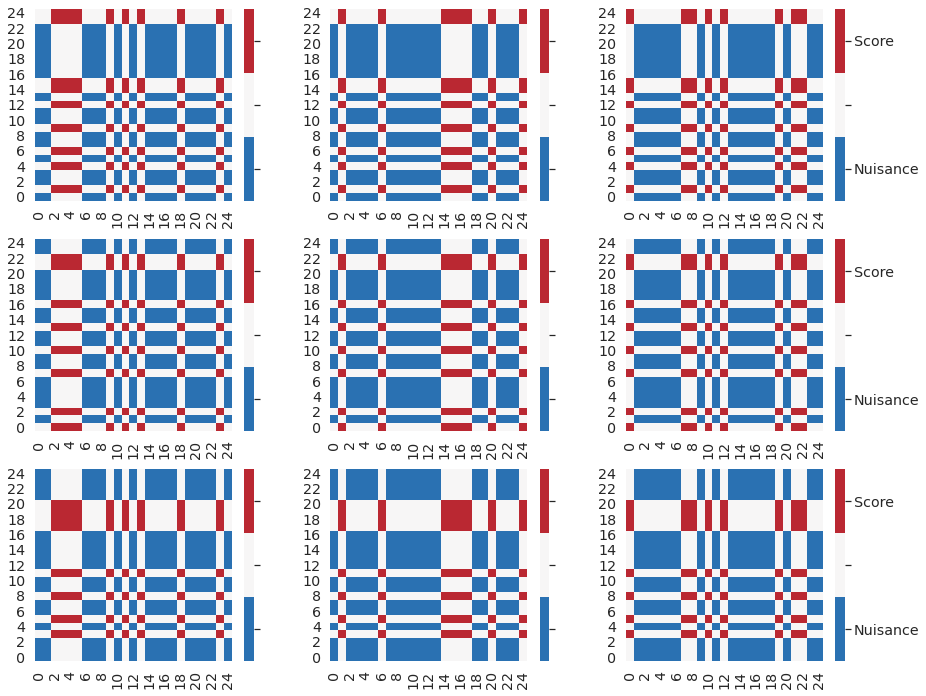

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



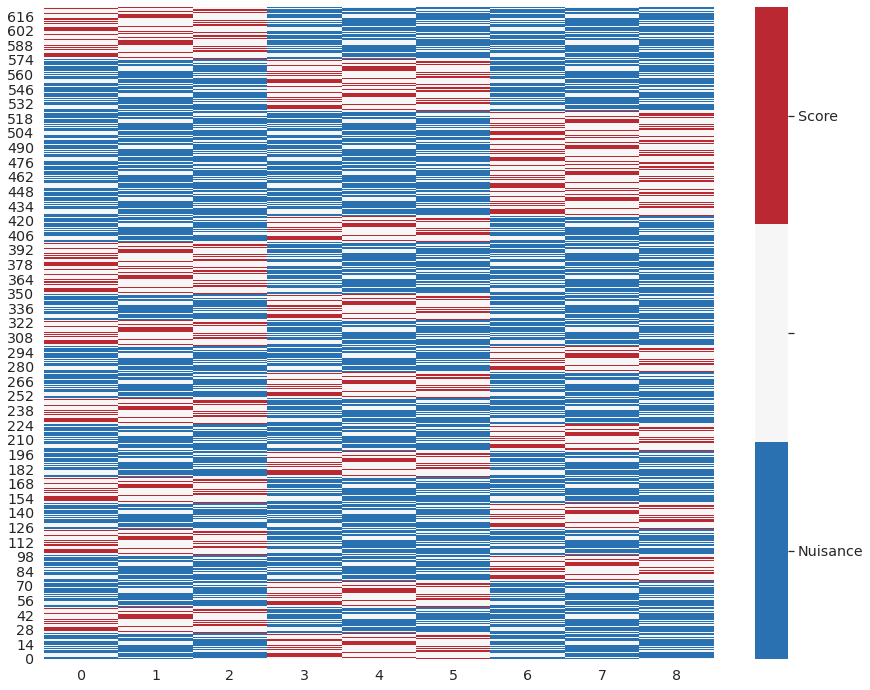

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])